# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# load data

In [2]:
df = pd.read_excel("data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls")
df.rename(columns={df.columns[0]: "datetime"}, inplace=True)
df.rename(columns={df.columns[1]: "sensor1"}, inplace=True)
df.rename(columns={df.columns[2]: "sensor2"}, inplace=True)
datetime = df.pop("datetime")
df = df.applymap(lambda cell: float(str(cell).replace(",", ".")))

# plot sensor

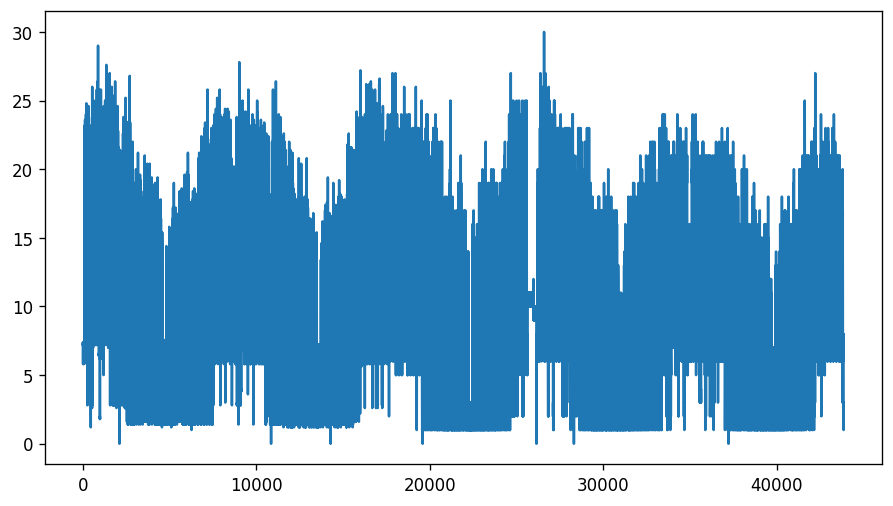

In [3]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
plt.plot(df["sensor2"])
plt.show()

# additative seasonal components

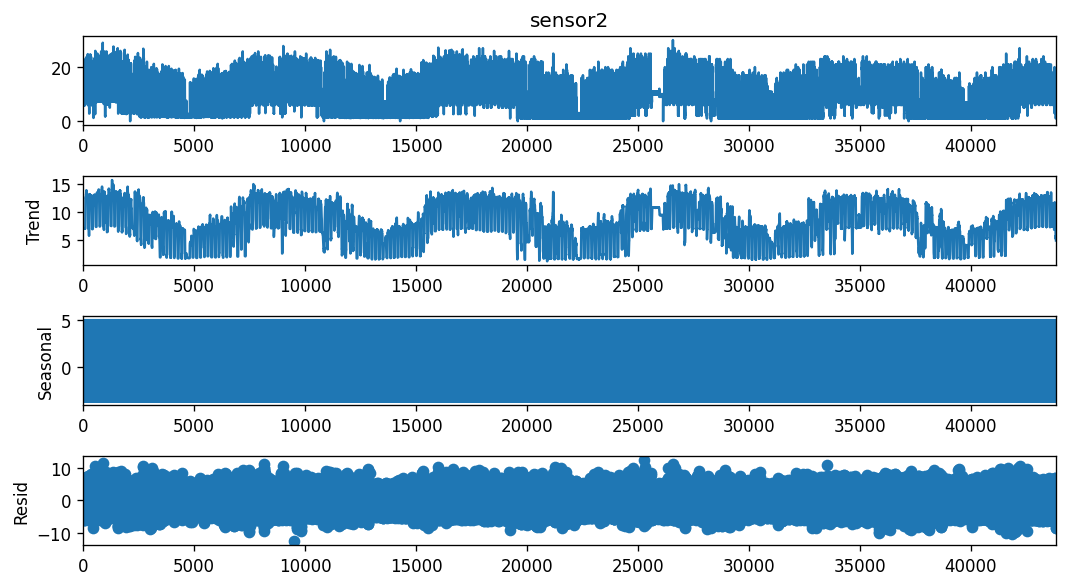

In [4]:
result_mul = seasonal_decompose(df["sensor2"], model='additative', extrapolate_trend='freq', period=24)
result_mul.plot()
plt.show()

# test stationary

In [5]:
# ADF Test
result = adfuller(df["sensor2"].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'{key}, {value}')

ADF Statistic: -21.156382217538873
p-value: 0.0
Critial Values:
1%, -3.430499321474984
Critial Values:
5%, -2.8616059968192618
Critial Values:
10%, -2.5668051279600483


# subtract best fit line (detrend)

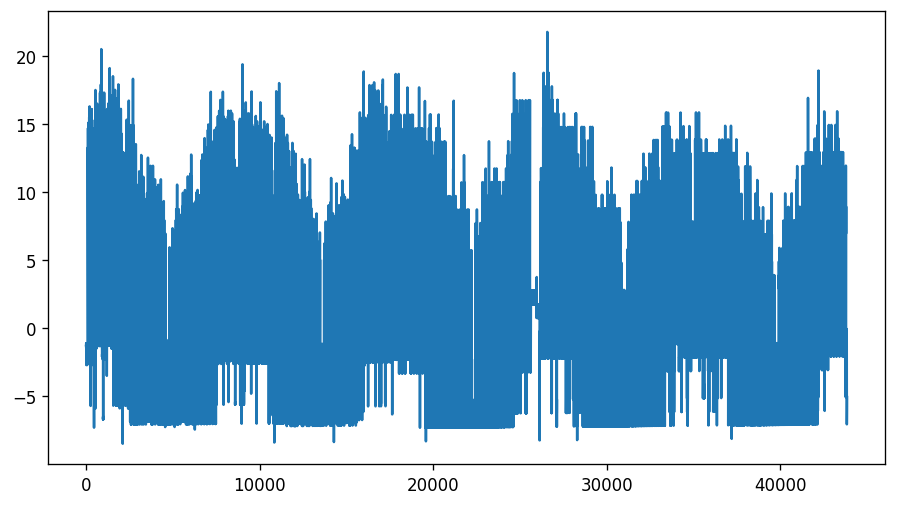

In [6]:
detrended = signal.detrend(df["sensor2"].values)
plt.plot(detrended)
plt.show()

# subtract trend component

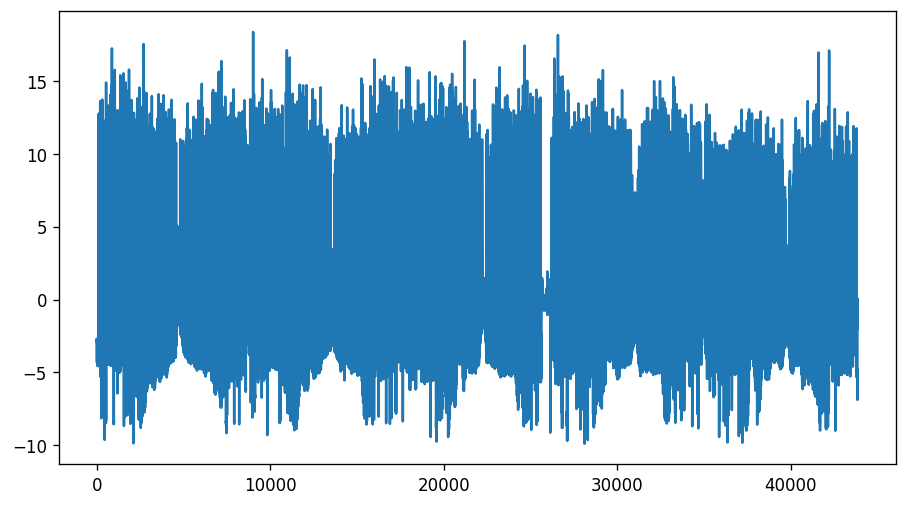

In [7]:
result_mul = seasonal_decompose(df['sensor2'], model='additative', extrapolate_trend='freq', period=24*7)
detrended = df["sensor2"].values - result_mul.trend
plt.plot(detrended)
plt.show()

# deseasonilize

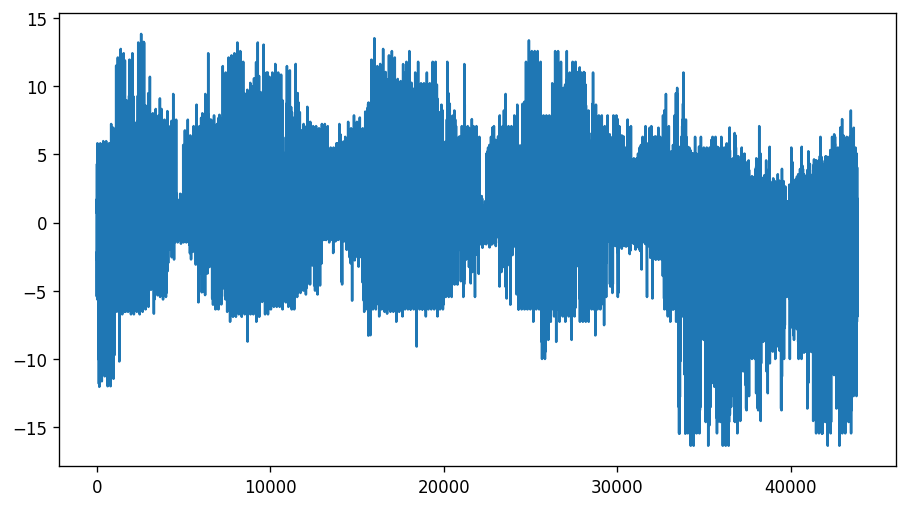

In [8]:
result_mul = seasonal_decompose(df['sensor2'], model='additative', extrapolate_trend='freq', period=24*7)
detrended = df["sensor2"].values - result_mul.trend
deseasonalized = df["sensor2"].values / result_mul.seasonal
plt.plot(deseasonalized)
plt.show()

# check for seasonality

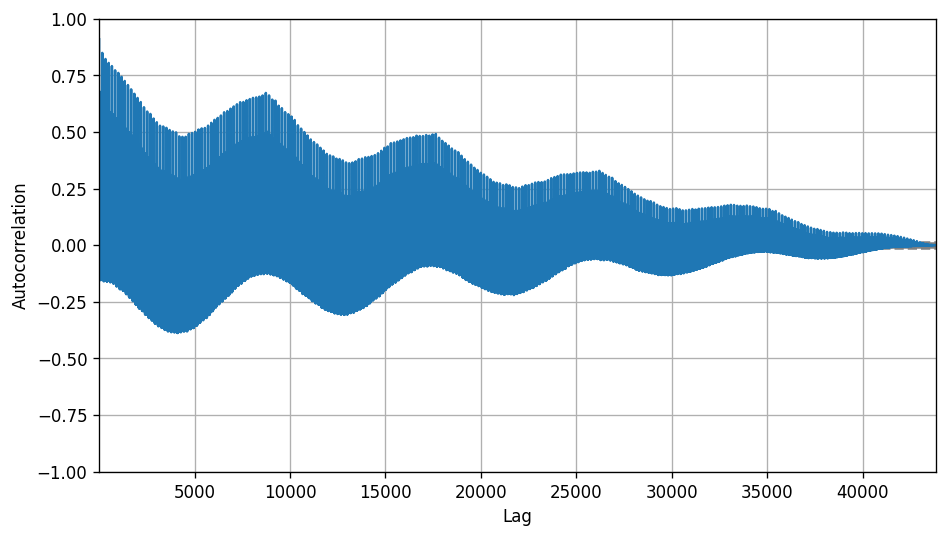

In [9]:
autocorrelation_plot(df['sensor2'].values.tolist())
plt.show()

# autocorrelation

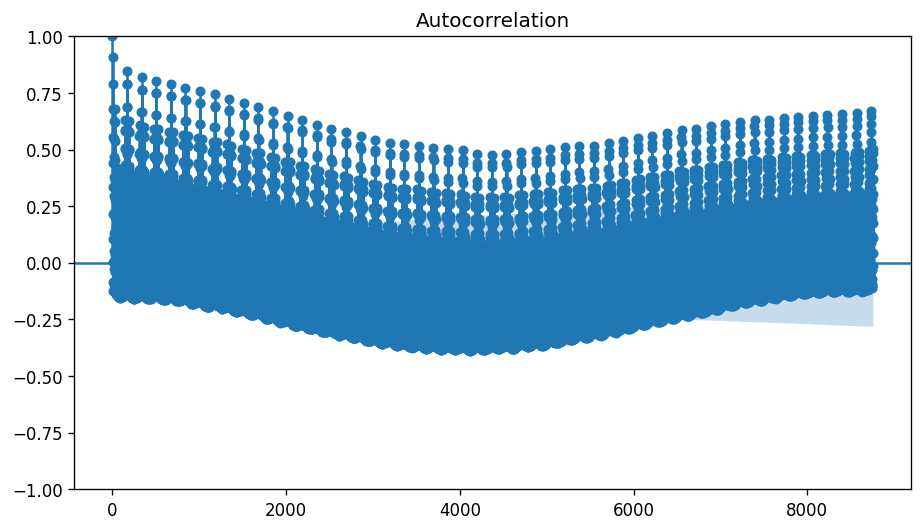

In [10]:
plot_acf(df["sensor2"].values.tolist(), lags=24*365)
plt.show()

# partial autocorrelation

C:\Users\Jacob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


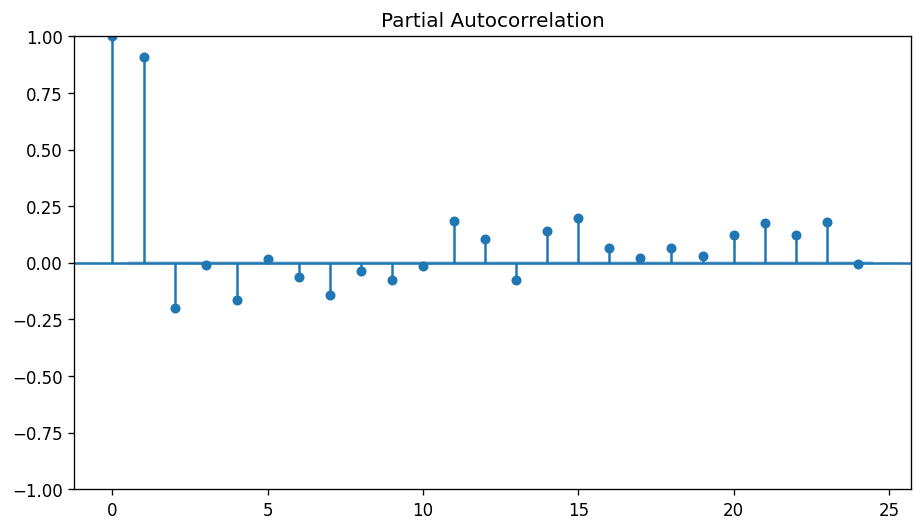

In [11]:
plot_pacf(df["sensor2"].values.tolist(), lags=24)
plt.show()

# lag plots

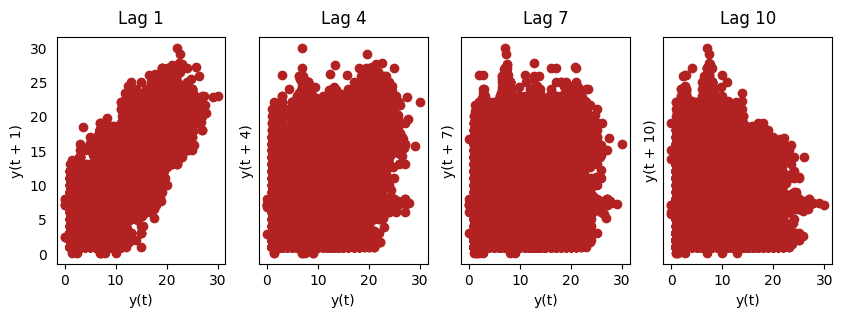

In [12]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    i*= 3
    lag_plot(df["sensor2"], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

plt.show()

# create arima model

In [13]:
model = ARIMA(df["sensor2"], order=(4,1,1))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\Jacob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jacob\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                sensor2   No. Observations:                43848
Model:                 ARIMA(4, 1, 1)   Log Likelihood             -102645.942
Date:                Wed, 09 Mar 2022   AIC                         205303.884
Time:                        17:31:35   BIC                         205356.015
Sample:                             0   HQIC                        205320.314
                              - 43848                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2237      0.051      4.388      0.000       0.124       0.324
ar.L2         -0.0870      0.010     -8.965      0.000      -0.106      -0.068
ar.L3          0.1130      0.006     18.520      0.0

# residuals

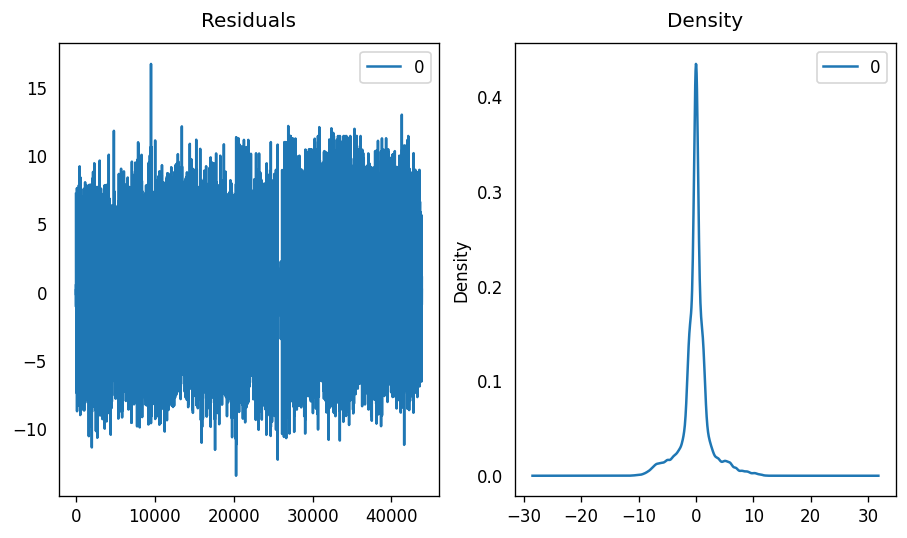

In [14]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# actual vs fitted

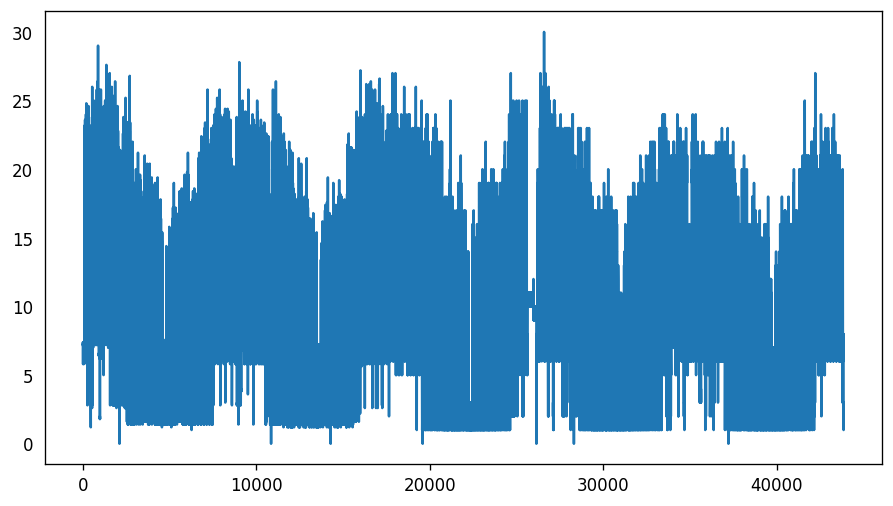

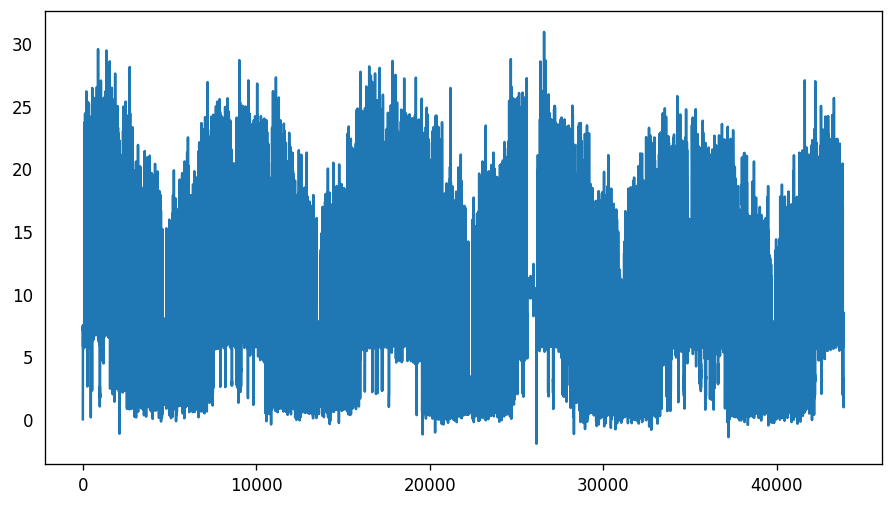

In [15]:
predict = model_fit.predict(dynamic=False)
plt.plot(df["sensor2"])
plt.show()
plt.plot(predict)
plt.show()

# validate

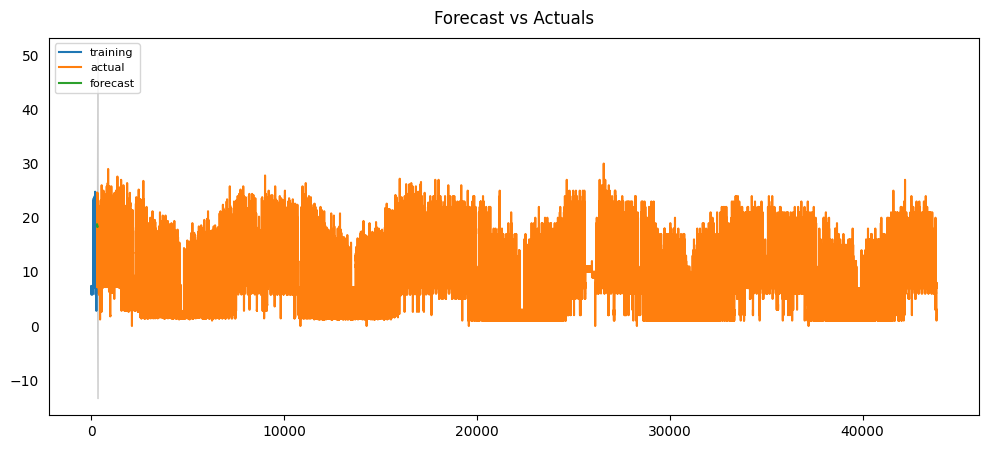

In [16]:
train = df['sensor2'][:300]
test = df['sensor2'][300:]

model = ARIMA(train, order=(4, 1, 1))  
fitted = model.fit()

sf = fitted.get_forecast(30, alpha=0.05).summary_frame()

# Forecast
fc = sf["mean"]
se = sf["mean_se"]
lower_series = sf["mean_ci_lower"]
upper_series = sf["mean_ci_upper"]

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(lower_series, index=test.index)
upper_series = pd.Series(upper_series, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#  create sarima model

In [19]:
smodel = pm.auto_arima(df["sensor2"][:100], start_p=1, start_q=1,
                         test='adf',
                         max_p=1, max_q=1, m=24,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=-62.425, Time=0.91 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=-18.973, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=-64.086, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=0.75 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=-61.198, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=-62.235, Time=2.93 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=1.18 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=-64.408, Time=0.27 sec
 ARIMA(1,1,0)(0,1,2)[24]             : AIC=-62.466, Time=3.37 sec
 ARIMA(1,1,0)(1,1,2)[24]             : AIC=inf, Time=9.52 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=-18.245, Time=0.42 sec
 ARIMA(1,1,0)(0,1,1)[24] intercept   : AIC=-62.409, Time=0.41 sec

Best model:  ARIMA(1,1,0)(0,1,1)[24]          
Total fit time: 20.065 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  100
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 24)   Log Likelihood                  35.204
Date:                              Wed, 09 Mar 2022   AIC                            -64.408
Time:                                      17:38:56   BIC                            -57.455
Sample:                                           0   HQIC                           -61.632
                                              - 100                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6975      0.093     -7.480      0.000      -0.880      -0.515
ma.S.L24      -0.3415      0.164     -2.088      0.037      -0.662      -0.021
sigma2         0.0218      0.003      7.008      0.000       0.016       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.91
Prob(Q):                              0.93   Prob(JB):                         0.23
Heteroskedasticity (H):               0.73   Skew:                             0.31
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# forecast

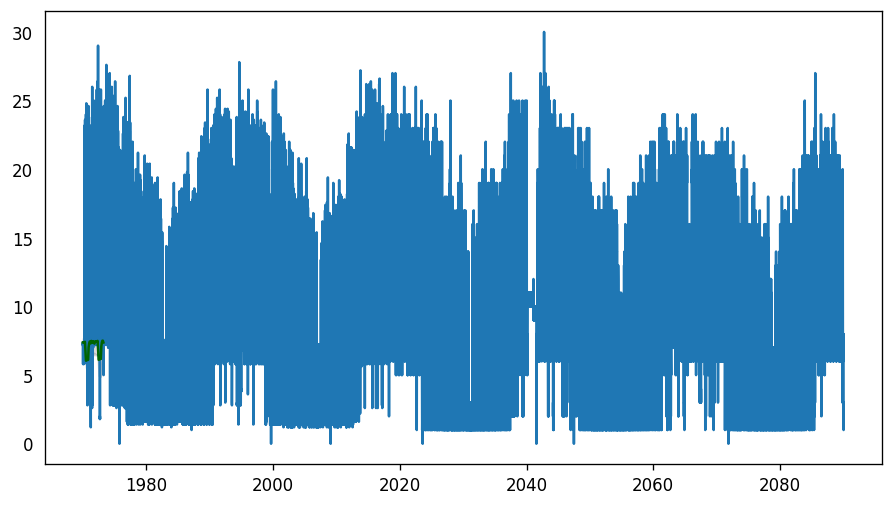

In [20]:
n_periods = 40
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df["sensor2"][:100].index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df["sensor2"])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.show()